In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
groups = [
    {'name': 'Control', 'total': 1361, 'observed': 157},
    {'name': 'Total', 'total': 1360, 'observed': 205},
    {'name': 'Opens', 'total': 585, 'observed': 102},
#     {'name': 'Control', 'total': 136, 'observed': 5},
#     {'name': 'Group A', 'total': 124, 'observed': 24},
#     {'name': 'Group B', 'total': 58, 'observed': 8},
]

In [421]:
def ratio(observed, total):
    
    return observed / total

In [422]:
ratios = [{'name': g['name'], 
           'total': g['total'], 
           'observed': g['observed'], 
           'ratio': ratio(g['observed'], g['total'])} 
          for g in groups]

In [423]:
ratios

[{'name': 'Control',
  'observed': 157,
  'ratio': 0.115356355620867,
  'total': 1361},
 {'name': 'Total',
  'observed': 205,
  'ratio': 0.15073529411764705,
  'total': 1360},
 {'name': 'Opens',
  'observed': 102,
  'ratio': 0.17435897435897435,
  'total': 585}]

Control 0.115356 0.115356355620867 0.4
Total 0.150735 0.15073529411764705 1.4
Opens 0.174359 0.17435897435897435 2.4000000000000004


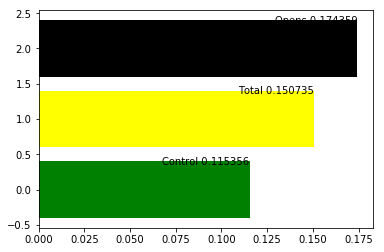

In [424]:
colors = ['green', 'yellow', 'black', 'grey']
fig, ax = plt.subplots()
rects = ax.barh(range(0, len(groups)), [r['ratio'] for r in ratios],
    color=colors)

labels = ['{:} {:2f}'.format(r['name'], r['ratio']) for r in ratios]
for rect, label in zip(rects, labels):
    x = rect.get_width()
    y = rect.get_height() + rect.get_y()
    print(label, x, y)
    ax.text(x, y, label, va='center', ha='right')


In [4]:
n_burn, n_samples = 1000, 3000
traces = []
for g in groups:
    
    model = pm.Model()
    with model:
        # Let's say the ratio is uniform between 0 and 1
        r = pm.Uniform('ratio', 0, 1)

        # Now let's assume the *expected* number of observations is really just
        # the total multiplied by the ratio
        e = pm.Deterministic('e', g['total'] * r)
        # The observed number of transactions is a Poisson with mu set to the expectations
        a = pm.Poisson('a', e, observed=g['observed'])
        
        trace = pm.sample(n_samples, tune=n_burn)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 10.23:   5%|▍         | 9213/200000 [00:00<00:14, 12971.90it/s] 
Convergence archived at 10200
Interrupted at 10,200 [5%]: Average Loss = 84.838
100%|██████████| 4000/4000 [00:02<00:00, 1598.66it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 9.8163:   5%|▍         | 9115/200000 [00:00<00:14, 12987.63it/s]
Convergence archived at 10000
Interrupted at 10,000 [5%]: Average Loss = 65.028
100%|██████████| 4000/4000 [00:01<00:00, 2454.04it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 7.4369:   4%|▍         | 8539/200000 [00:00<00:15, 12202.72it/s]
Convergence archived at 9700
Interrupted at 9,700 [4%]: Average Loss = 26.602
100%|██████████| 4000/4000 [00:01<00:00, 2417.16it/s]


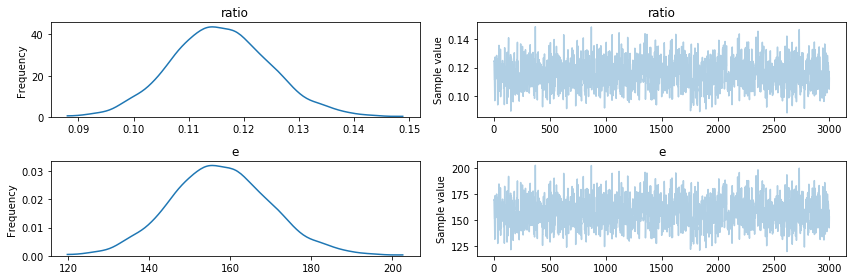

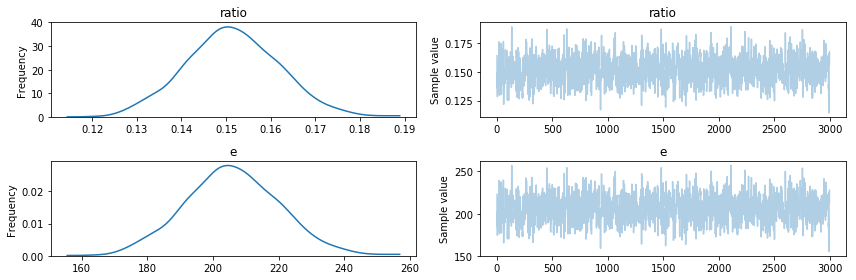

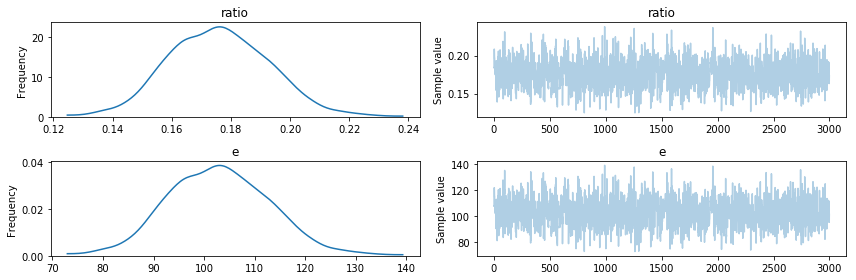

In [5]:
for trace in traces:
    pm.traceplot(trace)

,name,observed,total
0,Control,157,1361
1,Total,205,1360
2,Opens,102,585


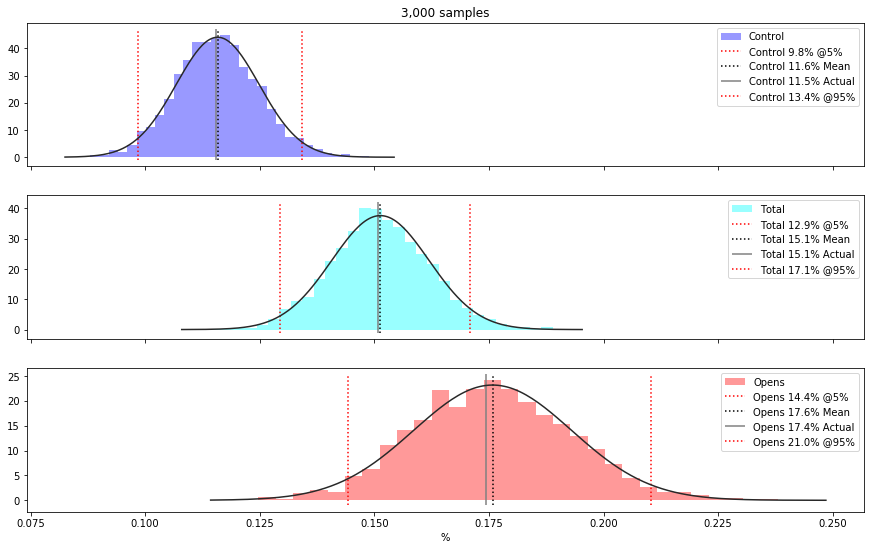

In [6]:
f, axarr = plt.subplots(len(traces), sharex=True, figsize=(15,9))
# plt.ylim((0, max_y))
max_y = 20
alpha = 0.05
colors = ['blue', 'cyan', 'red']
axarr[0].set_title('{:,} samples'.format(n_samples))
for g, trace in enumerate(traces):
    
    label = groups[g]['name']
    true_ratio =  groups[g]['observed']/groups[g]['total']
    hpd = pm.stats.hpd(trace['ratio'], alpha=alpha)
    m = trace['ratio'].mean()
    q = pm.stats.quantiles(trace['ratio'])
#     print(q, hpd)
    sns.distplot(trace['ratio'], bins=30, hist=True, kde=False, norm_hist=True
                 , fit=scipy.stats.norm
                 , label=label
                 , ax=axarr[g]
                 , color=colors[g]
                )
    y_min, y_max = axarr[g].get_ylim()
    axarr[g].vlines(x=hpd[0], ymin=-1, ymax=y_max, linestyles='dotted', color='red',
               label='{:} {:.1%} @{:.0%}'.format(label, hpd[0], alpha))
    axarr[g].vlines(x=m, ymin=-1, ymax=y_max, linestyles='dotted', color='black',
               label='{:} {:.1%} Mean'.format(label, m))
    axarr[g].vlines(x=true_ratio, ymin=-1, ymax=y_max, linestyles='solid', color='gray',
               label='{:} {:.1%} Actual'.format(label, true_ratio))
    axarr[g].vlines(x=hpd[1], ymin=-1, ymax=y_max, linestyles='dotted', color='red',
               label='{:} {:.1%} @{:.0%}'.format(label, hpd[1], 1-alpha))
    axarr[g].legend()

axarr[-1].set_xlabel('%');
# plt.show()

pd.DataFrame(groups)

In [7]:
for g, trace in enumerate(traces):
    hpd = pm.stats.hpd(trace['ratio'])
    df = pm.df_summary(trace, ['ratio'])
    print(groups[g]['name'], 
          df['hpd_2.5'].values, 
          df['mean'].values, 
          df['hpd_97.5'].values)
#     print(pm.summary(trace))
#     fig = plt.figure(figsize=(10,3));
#     pm.plot_posterior(trace, varnames=['ratio']);
#     plt.show();

Control [ 0.09840925] [ 0.11581426] [ 0.13417808]
Total [ 0.12930769] [ 0.1513119] [ 0.17089355]
Opens [ 0.14413894] [ 0.17578919] [ 0.2103796]
